In [58]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn import cluster, mixture
from hdbscan import HDBSCAN

from itertools import cycle, islice

In [48]:
def make_spiral(N=500, noise=0.1, num_spirals=3, seed=None, start_cutoff=0.1, end_cutoff=0.0, scale=1.0):
    """Generate a spiral dataset."""
    np.random.seed(seed)
    spirals = []
    labels = []
    theta = np.sqrt(np.random.rand(N // num_spirals))
    # scale theta to be between start_cutoff and 2*pi - end_cutoff
    theta = theta * (2 * np.pi * (1 - start_cutoff - end_cutoff)) + start_cutoff * 2 * np.pi
    scale = scale / (2 * np.pi)
    for i in range(num_spirals):
        theta_i = theta + (i * 2 * np.pi / num_spirals)
        data = np.array([scale * theta * np.cos(theta_i), scale * theta * np.sin(theta_i)]).T
        data = data + noise * np.random.randn(*data.shape) * scale
        spirals.append(data)
        labels.append(np.ones(N // num_spirals) * i)
    return np.vstack(spirals), np.hstack(labels)

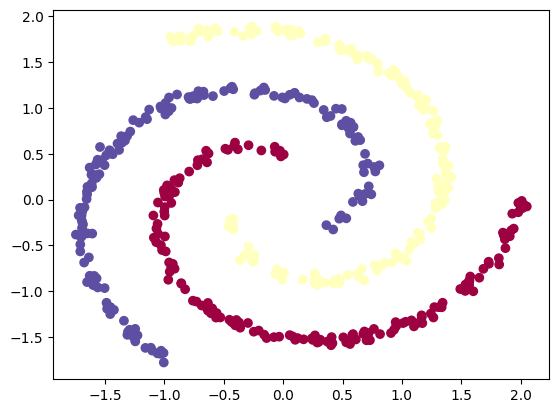

In [51]:
spirals, labels = make_spiral(scale=2.0)
plt.scatter(spirals[:, 0], spirals[:, 1], c=labels, cmap='Spectral')

In [69]:
n_samples = 500
noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
spirals = make_spiral(n_samples, seed=42, scale=2.0)

# Anisotropicly distributed data
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (
        spirals,
        {}
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

<Figure size 2100x1300 with 0 Axes>

c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\cluster\_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\cluster\_agglomerative.py:552: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change fro

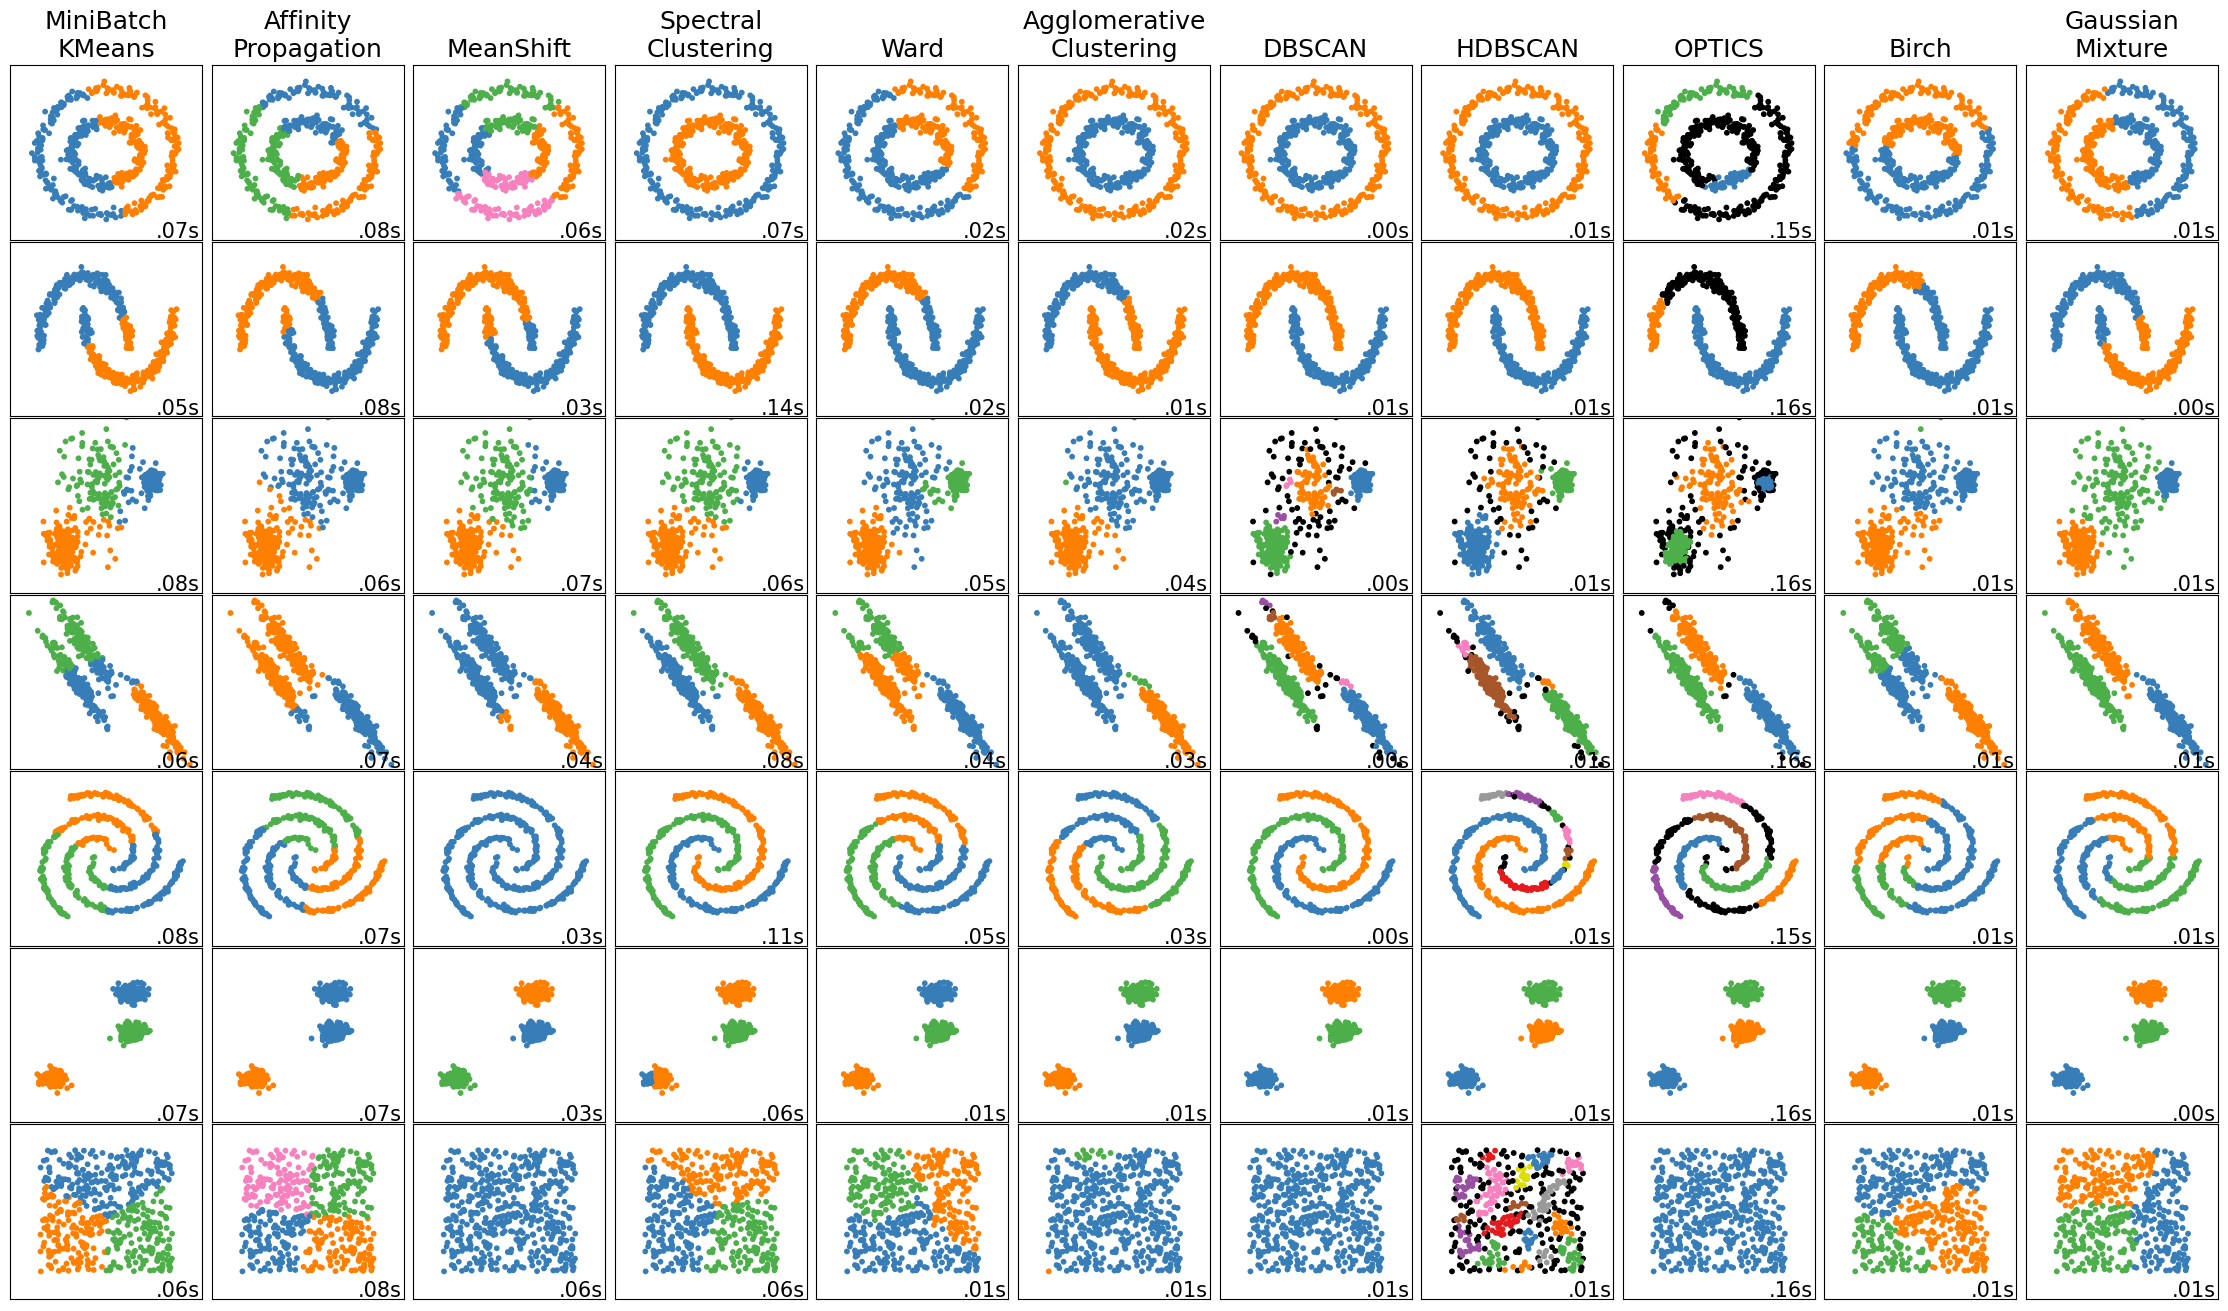

In [71]:
plot_num = 1
plt.figure(figsize=(10 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = DBSCAN(eps=params["eps"])
    hdbscan = HDBSCAN()
    optics = OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=42
    )
    average_linkage = AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = Birch(n_clusters=params["n_clusters"])
    gmm = GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full", random_state=42
    )
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("Birch", birch),
        ("Gaussian\nMixture", gmm),
    )
    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " + 
                "connectivity matrix is [0-9]{1,2}" + 
                "> 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        color = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=color[y_pred])
        
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num+=1

plt.show()